In [1]:
# Cell 1: Install required libraries (run once if not installed)
!pip install transformers datasets torch transformer_lens pandas numpy tqdm

In [2]:
# Cell 2: Import libraries
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
import transformer_lens
from transformer_lens import HookedTransformer
import os

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Cell 3: Load GPT-2 Small model and tokenizer
model_name = "gpt2"  # GPT-2 Small (124M parameters); change to "google/gemma-2b" or others as needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# Add padding token if not present (GPT-2 doesn’t have one by default)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

# Verify model size
print(f"Model: {model_name}, Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")

Model: gpt2, Parameters: 124.44M


In [4]:
# Cell 4: Load and preprocess IMDb dataset (Fixed)
dataset = load_dataset("imdb")
print(dataset)

# Define formatting function
def format_imdb_example(example):
    label_map = {0: "negative", 1: "positive"}
    prompt = f"Review: {example['text']} Sentiment: {label_map[example['label']]}"
    return {"text": prompt, "label": example["label"]}  # Keep label for filtering

# Apply formatting and explicitly save results
train_dataset = dataset["train"].map(format_imdb_example)
val_dataset = dataset["test"].map(format_imdb_example)

# Take subsets
train_dataset = train_dataset.select(range(1000))
val_dataset = val_dataset.select(range(200))
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

# Inspect a sample to confirm formatting
print("Sample from val_dataset:", val_dataset[0])

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Train size: 1000, Val size: 200
Sample from val_dataset: {'text': 'Review: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre tha

In [5]:
# Cell 5: Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256,  # Adjust based on your needs
        return_tensors="pt"
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask"])

In [6]:
# Cell 6: Test model with a sample batch
sample_batch = tokenized_train[:2]  # Take 2 examples
input_ids = sample_batch["input_ids"].to(device)
attention_mask = sample_batch["attention_mask"].to(device)

outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
loss = outputs.loss
print(f"Sample loss: {loss.item()}")

# Decode a sample to check formatting
sample_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
print(f"Sample input: {sample_text}")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Sample loss: 3.5917704105377197
Sample input: Review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, 

# Baseline measurement

In [7]:
# Cell 7: Load Transformer Lens model (Fixed)
from transformer_lens import HookedTransformer

# Load Hugging Face model without moving it to device yet
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)  # Keep on CPU initially

# Convert to Transformer Lens, specifying the device
tl_model = HookedTransformer.from_pretrained(
    model_name,
    hf_model=model,
    device=device  # Pass the device ("cuda" or "cpu") here
)

tl_model.eval()
print(f"Loaded Transformer Lens model: {model_name}")

Loaded pretrained model gpt2 into HookedTransformer
Loaded Transformer Lens model: gpt2


In [8]:
# Cell 8: Prepare validation subset for analysis (Updated)
def filter_by_label(dataset, label, max_samples=50):
    # Filter using the 'label' field (0 for negative, 1 for positive)
    filtered = [d for d in dataset if d["label"] == label]
    return filtered[:max_samples]

# Get positive and negative examples
pos_samples = filter_by_label(val_dataset, 1)  # 1 = positive
neg_samples = filter_by_label(val_dataset, 0)  # 0 = negative
print(f"Positive samples: {len(pos_samples)}, Negative samples: {len(neg_samples)}")

# Check if we have samples
if not pos_samples or not neg_samples:
    print("Error: One or both sample sets are empty. Adjusting...")
    pos_samples = [d for d in dataset["test"] if d["label"] == 1][:50]
    neg_samples = [d for d in dataset["test"] if d["label"] == 0][:50]
    print(f"Adjusted - Positive samples: {len(pos_samples)}, Negative samples: {len(neg_samples)}")

# Tokenize
pos_toks = tokenizer(
    [s["text"] for s in pos_samples],
    padding="max_length",
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
neg_toks = tokenizer(
    [s["text"] for s in neg_samples],
    padding="max_length",
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

pos_input_ids = pos_toks["input_ids"].to(device)
neg_input_ids = neg_toks["input_ids"].to(device)
pos_mask = pos_toks["attention_mask"].to(device)
neg_mask = neg_toks["attention_mask"].to(device)

Positive samples: 0, Negative samples: 50
Error: One or both sample sets are empty. Adjusting...
Adjusted - Positive samples: 50, Negative samples: 50


In [9]:
# Cell 9: Cache activations with disk saving and memory management
import os
import torch

def get_activations(model, input_ids, attention_mask, batch_size=10, save_dir="activations"):
    os.makedirs(save_dir, exist_ok=True)
    all_resid = [[] for _ in range(model.cfg.n_layers)]  # List to store per-layer activations
    
    # Process in smaller batches
    for i in range(0, input_ids.size(0), batch_size):
        batch_ids = input_ids[i:i + batch_size]
        batch_mask = attention_mask[i:i + batch_size]
        _, cache = model.run_with_cache(
            batch_ids,
            attention_mask=batch_mask,
            names_filter=lambda name: "resid_pre" in name
        )
        # Append activations for each layer
        for layer in range(model.cfg.n_layers):
            resid = cache[f"blocks.{layer}.hook_resid_pre"]
            all_resid[layer].append(resid.cpu())  # Move to CPU immediately
        del cache  # Free GPU memory
        torch.cuda.empty_cache()
    
    # Concatenate and save to disk
    for layer in range(model.cfg.n_layers):
        resid_tensor = torch.cat(all_resid[layer], dim=0)
        torch.save(resid_tensor, os.path.join(save_dir, f"layer_{layer}_resid.pt"))
        del resid_tensor  # Clear from CPU memory
    return None  # We’ll load from disk later

# Directory for saving activations
pos_save_dir = "activations_positive"
neg_save_dir = "activations_negative"

# Get and save activations
print("Caching positive activations...")
get_activations(tl_model, pos_input_ids, pos_mask, batch_size=10, save_dir=pos_save_dir)
print("Caching negative activations...")
get_activations(tl_model, neg_input_ids, neg_mask, batch_size=10, save_dir=neg_save_dir)

# Free memory after caching
del pos_input_ids, pos_mask, neg_input_ids, neg_mask
torch.cuda.empty_cache()
print("Activations saved to disk and memory cleared.")

Caching positive activations...
Caching negative activations...
Activations saved to disk and memory cleared.


Layer 0: Sentiment direction norm = 0.3947
Layer 1: Sentiment direction norm = 5.3281
Layer 2: Sentiment direction norm = 6.1339
Layer 3: Sentiment direction norm = 6.6156
Layer 4: Sentiment direction norm = 7.0147


Layer 5: Sentiment direction norm = 8.1803
Layer 6: Sentiment direction norm = 8.9491
Layer 7: Sentiment direction norm = 9.7784
Layer 8: Sentiment direction norm = 11.9595
Layer 9: Sentiment direction norm = 14.2080
Layer 10: Sentiment direction norm = 17.1533
Layer 11: Sentiment direction norm = 21.1554


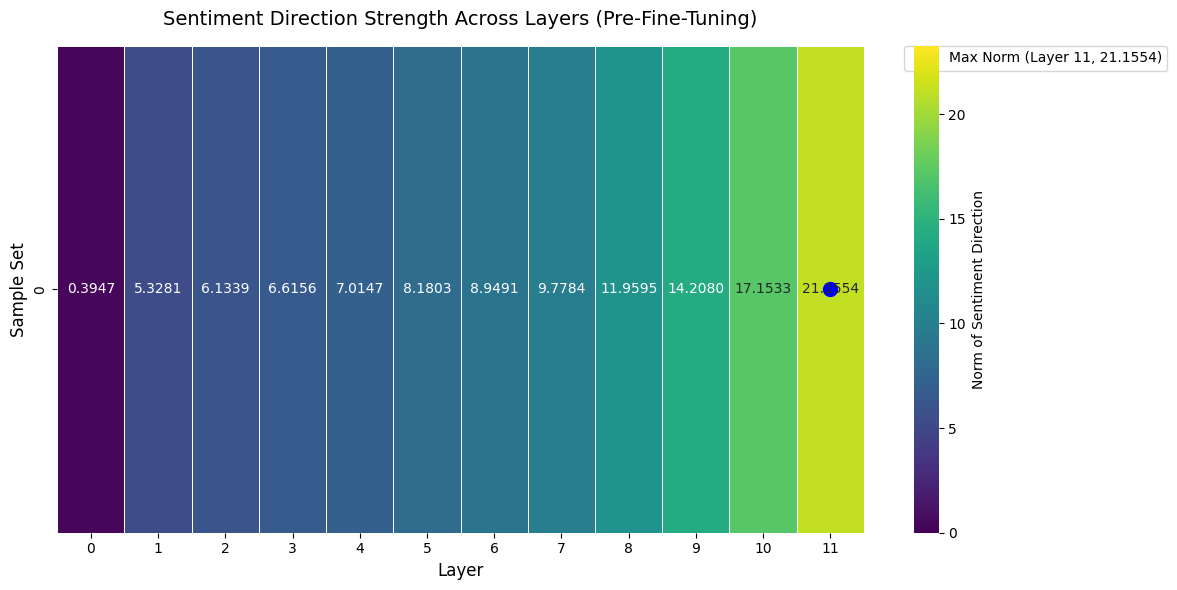

In [16]:
# Cell 10: Compute and plot sentiment direction per layer as a professional heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import os

# Load activations and compute norms
n_layers = tl_model.cfg.n_layers
layer_norms = []

for layer in range(n_layers):
    # Load activations from disk
    pos_resid = torch.load(os.path.join(pos_save_dir, f"layer_{layer}_resid.pt"))
    neg_resid = torch.load(os.path.join(neg_save_dir, f"layer_{layer}_resid.pt"))
    
    # Compute mean at last token position
    pos_mean = pos_resid[:, -1, :].mean(dim=0)
    neg_mean = neg_resid[:, -1, :].mean(dim=0)
    sentiment_dir = pos_mean - neg_mean
    norm = torch.norm(sentiment_dir).item()
    
    layer_norms.append(norm)
    print(f"Layer {layer}: Sentiment direction norm = {norm:.4f}")
    
    # Clean up
    del pos_resid, neg_resid, pos_mean, neg_mean, sentiment_dir
    torch.cuda.empty_cache()

# Create a heatmap-like data structure (1 row, n_layers columns)
data = np.array(layer_norms).reshape(1, -1)

# Find the layer with the maximum norm for annotation
max_norm_idx = np.argmax(layer_norms)
max_norm_value = layer_norms[max_norm_idx]

# Create the plot
plt.figure(figsize=(12, 6))  # Larger figure for clarity
sns.heatmap(
    data,
    cmap="viridis",  # Use viridis colormap
    annot=True,      # Show values in cells
    fmt='.4f',       # Format norms to 4 decimal places
    cbar_kws={'label': 'Norm of Sentiment Direction'},  # Colorbar label
    vmin=0, vmax=max(layer_norms) * 1.1,  # Scale colorbar from 0 to max + 10%
    linewidths=0.5,  # Thin lines between cells
    linecolor='white'
)

# Customize the plot
plt.title('Sentiment Direction Strength Across Layers (Pre-Fine-Tuning)', fontsize=14, pad=15)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Sample Set', fontsize=12)  # Adjusted to reflect the single row structure

# Highlight the layer with max norm (similar to blue boxes in your image)
plt.plot(max_norm_idx + 0.5, 0.5, 'bo', markersize=10, label=f'Max Norm (Layer {max_norm_idx}, {max_norm_value:.4f})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Final memory cleanup
del layer_norms, data
torch.cuda.empty_cache()

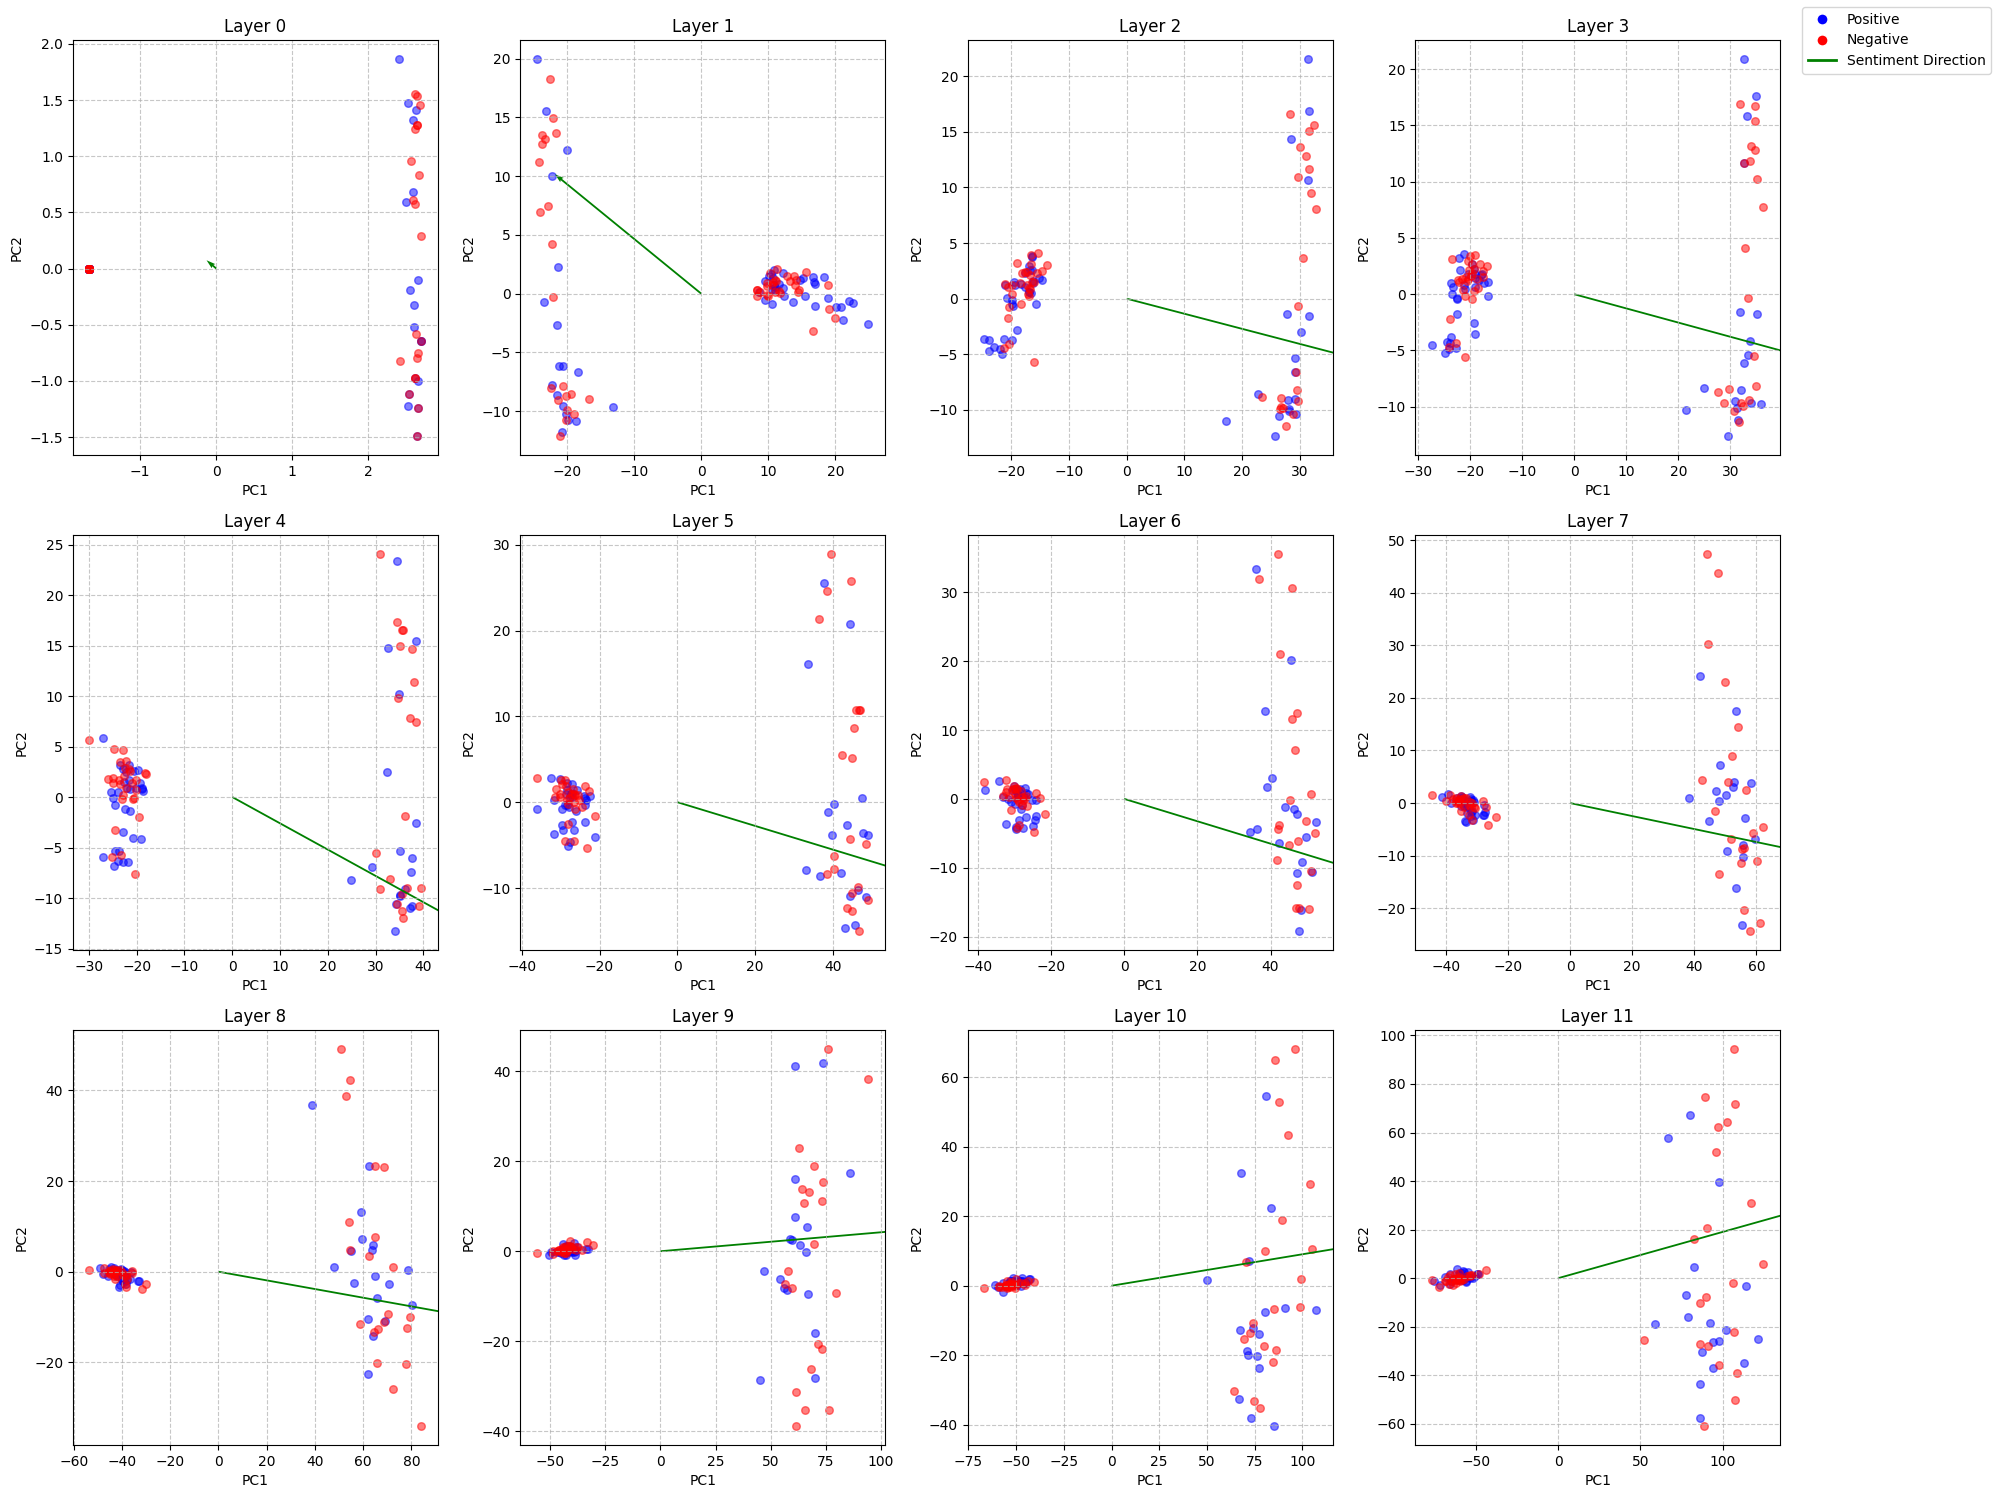

Memory cleared.


In [20]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.lines as mlines

# Set up a grid for 12 subplots: 3 rows x 4 columns
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axs = axs.flatten()

for layer in range(12):
    # Build paths for the positive and negative activations for this layer
    pos_resid_path = os.path.join("activations_positive", f"layer_{layer}_resid.pt")
    neg_resid_path = os.path.join("activations_negative", f"layer_{layer}_resid.pt")
    
    # Load activations on CPU and extract the last token (shape: [batch, d_model])
    pos_acts = torch.load(pos_resid_path, map_location='cpu')[:, -1, :].numpy()
    neg_acts = torch.load(neg_resid_path, map_location='cpu')[:, -1, :].numpy()
    
    # Combine the activations and perform PCA to reduce to 2 dimensions
    all_acts = np.concatenate([pos_acts, neg_acts], axis=0)
    pca = PCA(n_components=2)
    pca_acts = pca.fit_transform(all_acts)
    
    # Split the PCA results back into positive and negative groups
    pos_pca = pca_acts[:len(pos_acts)]
    neg_pca = pca_acts[len(pos_acts):]
    
    # Compute the sentiment direction (difference of means) and project it to 2D
    pos_mean = torch.tensor(pos_acts).mean(dim=0)
    neg_mean = torch.tensor(neg_acts).mean(dim=0)
    sentiment_dir = (pos_mean - neg_mean).numpy()
    sentiment_dir_2d = pca.transform(sentiment_dir.reshape(1, -1))
    
    # Plot on the corresponding subplot
    ax = axs[layer]
    ax.scatter(pos_pca[:, 0], pos_pca[:, 1], c='blue', alpha=0.5, s=30, label='Positive')
    ax.scatter(neg_pca[:, 0], neg_pca[:, 1], c='red', alpha=0.5, s=30, label='Negative')
    ax.quiver(0, 0, sentiment_dir_2d[0, 0], sentiment_dir_2d[0, 1],
              color='green', scale=10, width=0.005, label='Sentiment Direction')
    ax.set_title(f"Layer {layer}", fontsize=12)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Clean up variables for this iteration to free memory
    del pos_acts, neg_acts, all_acts, pca_acts, pos_pca, neg_pca, sentiment_dir, sentiment_dir_2d, pca
    torch.cuda.empty_cache()

# Create a common legend using proxy artists
pos_legend = mlines.Line2D([], [], marker='o', color='w',
                           markerfacecolor='blue', markersize=8, label='Positive')
neg_legend = mlines.Line2D([], [], marker='o', color='w',
                           markerfacecolor='red', markersize=8, label='Negative')
sent_legend = mlines.Line2D([], [], color='green', lw=2, label='Sentiment Direction')
fig.legend(handles=[pos_legend, neg_legend, sent_legend],
           loc='upper right', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("Memory cleared.")
